In [6]:
# Imports and plotting preferences
import os
import numpy as np
from sklearn.mixture import GMM
from astropy.io import fits
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

sns.set(style='white', font_scale=1.6, palette='deep')
col = sns.color_palette()

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [7]:
# Class to read, write, and sample from a mixture model.
class GaussianMixtureModel(object):

    def __init__(self, weights, means, covars, covtype):
        self.weights = weights
        self.means = means
        self.covars = covars
        self.covtype = covtype
        self.n_components, self.n_dimensions = self.means.shape
    
    @staticmethod
    def save(model, filename):
        hdus = fits.HDUList()
        hdr = fits.Header()
        hdr['covtype'] = model.covariance_type
        hdus.append(fits.ImageHDU(model.weights_, name='weights', header=hdr))
        hdus.append(fits.ImageHDU(model.means_, name='means'))
        hdus.append(fits.ImageHDU(model.covars_, name='covars'))
        hdus.writeto(filename, clobber=True)

    @staticmethod
    def load(filename):
        hdus = fits.open(filename, memmap=False)
        hdr = hdus[0].header
        covtype = hdr['covtype']
        model = GaussianMixtureModel(
            hdus['weights'].data, hdus['means'].data, hdus['covars'].data, covtype)
        hdus.close()
        return model
        
    def sample(self, n_samples=1, random_state=None):
        
        if self.covtype != 'full':
            return NotImplementedError(
                'covariance type "{0}" not implemented yet.'.format(self.covtype))
        
        # Code adapted from sklearn's GMM.sample()
        if random_state is None:
            random_state = np.random.RandomState()

        weight_cdf = np.cumsum(self.weights)
        X = np.empty((n_samples, self.n_dimensions))
        rand = random_state.rand(n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = random_state.multivariate_normal(
                    self.means[comp], self.covars[comp], num_comp_in_X)
        return X

In [8]:
# Simple function to compute the Bayesian information criterion.
def getbic(X, ncomp=[3]):
    bic = [GMM(n_components=nc, covariance_type="full").fit(X).bic(X) for nc in ncomp]
    #for ii in range(len(ncomp)):
    #    print(ncomp[ii], bic[ii])
    return bic

In [9]:
# Define the valid ranges. MoGs are sensitive to outliers.
grrange = (-0.2, 2.0)
rzrange = (-0.4, 2.5)

In [16]:
# Output file names
star_mogfile = os.path.join(os.getenv('LEGACYPIPE_DIR'), 'py', 'legacypipe', 'data', 'star_colors_mog.fits')
elg_mogfile = os.path.join(os.getenv('LEGACYPIPE_DIR'), 'py', 'legacypipe', 'data', 'elg_colors_mog.fits')

##Model the g-r, r-z color-color sequence for stars

In [4]:
# Build a sample of stars with good photometry from a single sweep.
rbright = 18
rfaint = 19.5
sweep = fits.getdata('sweep-340p000-350p005.fits', 1)
keep = np.where((sweep['TYPE'].strip() == 'PSF')*
                (np.sum((sweep['DECAM_FLUX'][:, [1,2,4]] > 0)*1, axis=1)==3)*
                (np.sum((sweep['DECAM_ANYMASK'][:, [1,2,4]] > 0)*1, axis=1)==0)*
                (np.sum((sweep['DECAM_FRACFLUX'][:, [1,2,4]] < 0.05)*1, axis=1)==3)*
                (sweep['DECAM_FLUX'][:,2]<(10**(0.4*(22.5-rbright))))*
                (sweep['DECAM_FLUX'][:,2]>(10**(0.4*(22.5-rfaint)))))[0]
stars = sweep[keep]
print('Found {} stars with good photometry.'.format(len(stars)))
gg = 22.5-2.5*np.log10(stars['DECAM_FLUX'][:, 1])
rr = 22.5-2.5*np.log10(stars['DECAM_FLUX'][:, 2])
zz = 22.5-2.5*np.log10(stars['DECAM_FLUX'][:, 4])
gr = gg - rr
rz = rr - zz
Xall = np.array([rz, gr]).T

Found 16936 stars with good photometry.


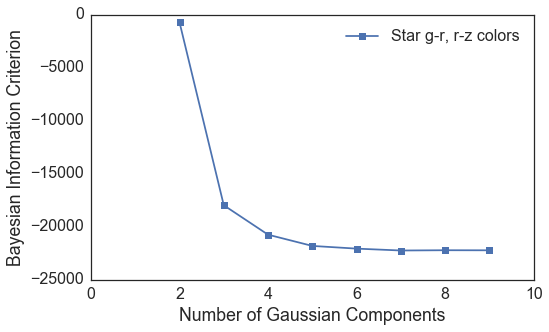

In [7]:
# Determine how many Gaussian components we need by looking at the Bayesian 
# Information Criterion.
ncomp = np.arange(2, 10)
bic = getbic(Xall, ncomp)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(ncomp, bic, marker='s', ls='-')
ax.set_xlim((0, 10))
ax.set_xlabel('Number of Gaussian Components')
ax.set_ylabel('Bayesian Information Criterion')
plt.legend(labels=['Star g-r, r-z colors'])
plt.tight_layout()
plt.show()       

In [8]:
# Model the distribution using a mixture of Gaussians and write out.
ncomp = 6 # from figure above
mog = GMM(n_components=ncomp, covariance_type="full").fit(Xall)
print('Writing {}'.format(star_mogfile))
GaussianMixtureModel.save(mog, star_mogfile)

Writing /Users/ioannis/repos/git/legacysurvey/legacypipe/py/data/star_colors_mog.fits


In [9]:
# Reread and sample from the MoGs.
mog = GaussianMixtureModel.load(star_mogfile)
samp = mog.sample(1500)

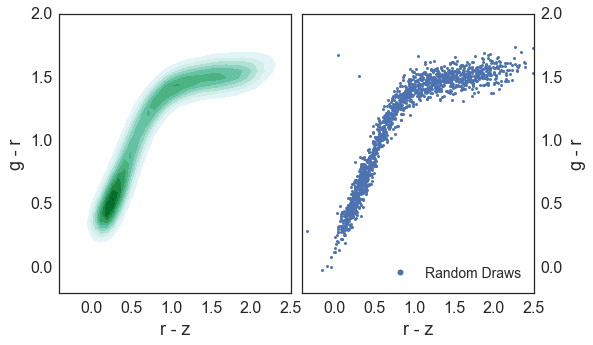

In [10]:
# Build a color-color plot.  Show the data on the left-hand panel and random draws from 
# the MoGs on the right-hand panel. 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5, 5), sharey=True)
                                                    
sns.kdeplot(rz, gr, clip=(rzrange, grrange), ax=ax1, gridsize=40,
            shade=True, cut=0, shade_lowest=False, label='DECaLS Stars')
ax1.set_xlim(rzrange)
ax1.set_ylim(grrange)
ax1.set_xlabel('r - z')
ax1.set_ylabel('g - r')
#ax1.legend(loc='lower right', prop={'size': 14}, labelspacing=0.25, markerscale=2)

ax2.plot(samp[:,0], samp[:,1], 'o', label='Random Draws', c=col[0], markersize=3)
ax2.set_xlim(rzrange)
ax2.set_ylim(grrange)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel('r - z')
ax2.set_ylabel('g - r')
ax2.legend(loc='lower right', prop={'size': 14}, labelspacing=0.25, markerscale=2)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()


## Model the g-r, r-z color-color sequence for ELGs

In [31]:
# Grab the sample DEEP2 ELGs whose SEDs have been modeled.
elgs = fits.getdata('elg_templates_v2.0.fits', 1)
morph = np.where(elgs['radius_halflight'] > 0)[0]

print('Grabbed {} ELGs, of which {} have HST morphologies.'.format(len(elgs), len(morph)))
gg = elgs['DECAM_G']
rr = elgs['DECAM_R']
zz = elgs['DECAM_Z']
gr = gg - rr
rz = rr - zz
Xall = np.array([rz, gr]).T

r50 = elgs['RADIUS_HALFLIGHT'][morph]
sersicn = elgs['SERSICN'][morph]                            

Grabbed 7735 ELGs, of which 734 have HST morphologies.


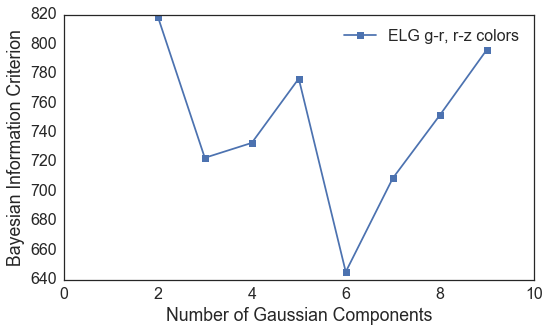

In [14]:
# Determine how many Gaussian components we need by looking at the Bayesian 
# Information Criterion.
ncomp = np.arange(2, 10)
bic = getbic(Xall, ncomp)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(ncomp, bic, marker='s', ls='-')
ax.set_xlim((0, 10))
ax.set_xlabel('Number of Gaussian Components')
ax.set_ylabel('Bayesian Information Criterion')
plt.legend(labels=['ELG g-r, r-z colors'])
plt.tight_layout()
plt.show()       

In [17]:
# Model the distribution using a mixture of Gaussians and write out.
ncomp = 6 # from figure above
mog = GMM(n_components=ncomp, covariance_type="full").fit(Xall)
print('Writing {}'.format(elg_mogfile))
GaussianMixtureModel.save(mog, elg_mogfile)

Writing /Users/ioannis/repos/git/legacysurvey/legacypipe/py/legacypipe/data/elg_colors_mog.fits


In [18]:
# Reread and sample from the MoGs.
mog = GaussianMixtureModel.load(elg_mogfile)
samp = mog.sample(1500)

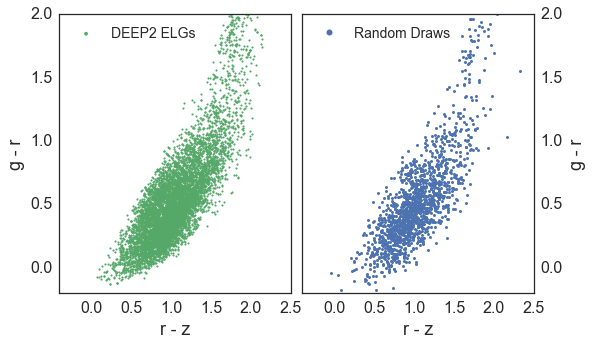

In [27]:
# Build a color-color plot.  Show the data on the left-hand panel and random draws from 
# the MoGs on the right-hand panel. 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5, 5), sharey=True)
     
ax1.scatter(rz, gr, s=3, color=col[1], label='DEEP2 ELGs')
#sns.kdeplot(rz, gr, clip=(rzrange, grrange), ax=ax1, gridsize=40,
#            shade=True, cut=0, shade_lowest=False, label='DECaLS ELGs')
ax1.set_xlim(rzrange)
ax1.set_ylim(grrange)
ax1.set_xlabel('r - z')
ax1.set_ylabel('g - r')
ax1.legend(loc='upper left', prop={'size': 14}, labelspacing=0.25, markerscale=2)

ax2.plot(samp[:,0], samp[:,1], 'o', label='Random Draws', c=col[0], markersize=3)
ax2.set_xlim(rzrange)
ax2.set_ylim(grrange)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel('r - z')
ax2.set_ylabel('g - r')
ax2.legend(loc='upper left', prop={'size': 14}, labelspacing=0.25, markerscale=2)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()


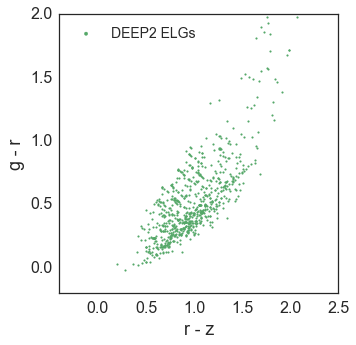

In [30]:
# Now look at the subset of ELGs with HST morphologies.  The "banding" in the colors probably comes from not doing the 
# K-corrections correctly, but we don't really care about that here.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5, 5))
     
ax1.scatter(rz[morph], gr[morph], s=3, color=col[1], label='DEEP2/HST ELGs')
#sns.kdeplot(rz, gr, clip=(rzrange, grrange), ax=ax1, gridsize=40,
#            shade=True, cut=0, shade_lowest=False, label='DECaLS ELGs')
ax1.set_xlim(rzrange)
ax1.set_ylim(grrange)
ax1.set_xlabel('r - z')
ax1.set_ylabel('g - r')
ax1.legend(loc='upper left', prop={'size': 14}, labelspacing=0.25, markerscale=2)

ax2
